# Distribution of distances from MD simulation using GFN-FF in xTB

Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

Read in the trajectory file `xtb.xyz` and input file, `md_input.inp`, find the total time (in ps) and the dump rate (in fs).

In [2]:
xtb = pd.read_csv('xtb.xyz')

In [3]:
with open('md_input.inp', 'r', encoding='utf-8') as md:
    lines = md.readlines()
    for line in lines:
        if 'time' in line:
            total_time = int(re.findall(pattern='\d+', string=line)[0])
        elif 'dump' in line:
            dump = float(re.findall(pattern='\d+\.\d+', string=line)[0])
            

Enter the locations of radicals in Avogadro (numbers of atoms) and title.

In [4]:
o1 = 160
o2 = 197
title = 'IH-873_negative control'

Extract the coordinates and put them in the dataframe.

In [5]:
#reading number of atoms

for col in xtb.columns:
    n_rows = int(col)+2
    
#Creating dataframes of separate atoms

df_o1 = xtb[xtb.index % n_rows == o1]
df_o2 = xtb[xtb.index % n_rows == o2]

# Get energies
df_e = xtb[xtb.index % n_rows == 0]


#Formatting strings, splitting into columns, delete the element column, setting type to float

df_o1 = df_o1['{}'.format(n_rows-2)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_o1 = df_o1.drop(columns=0).astype('float64').rename({1:'x1', 2:'y1', 3:'z1'}, axis=1).reset_index(drop=True)


df_o2 = df_o2['{}'.format(n_rows-2)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_o2 = df_o2.drop(columns=0).astype('float64').rename({1:'x2', 2:'y2', 3:'z2'}, axis=1).reset_index(drop=True)

df_e = df_e['{}'.format(n_rows-2)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)[2].reset_index(drop=True)


#Combining into single dataframe
coords = pd.concat([df_o1, df_o2, df_e], axis=1).rename({2:'energy'}, axis=1)
coords['time'] = np.arange(10, total_time*1000+10, dump)
try:
    coords['energy'] = coords['energy'].astype('float64')
except:
    coords = coords.drop(coords[coords['energy']=='gnorm:'].index)
    coords['energy'] = coords['energy'].astype('float64')




Calculate distance and add time.

In [6]:
coords['distance'] = np.sqrt((coords['x2'] - coords['x1'])**2 + (coords['y2'] - coords['y1'])**2 + (coords['z2'] - coords['z1'])**2)/10

coords['rel_energy'] = (coords['energy'] - coords['energy'].min())*627.5

Visualization, distance with time

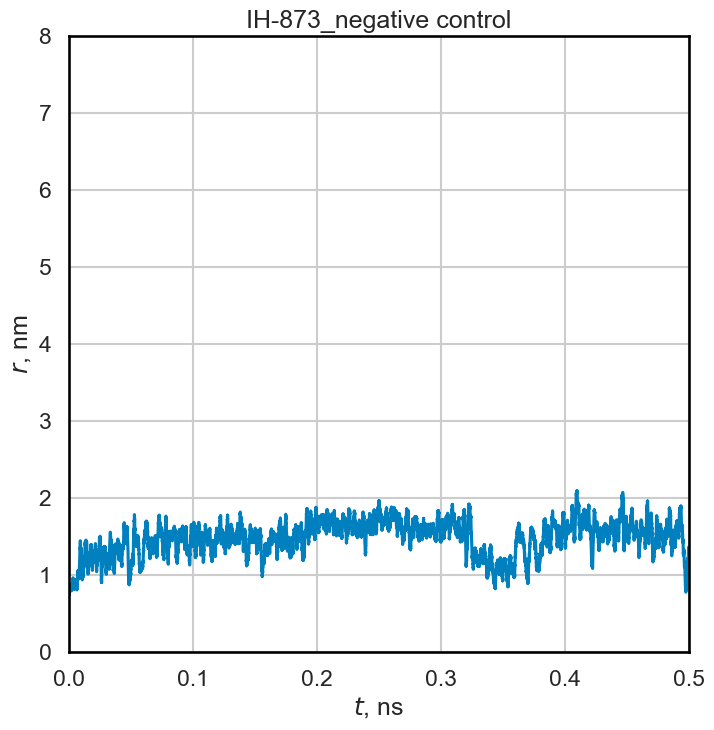

In [7]:
from matplotlib.ticker import FuncFormatter
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
sns.lineplot(data=coords, x="time", y="distance", color='#0080bf')
plt.xlim(0, total_time*1000)
plt.ylim([0,8])
ticks = lambda x,pos: f'{x/1000000:.1f}'
fmt = FuncFormatter(ticks)

ax = plt.gca()
ax.xaxis.set_major_formatter(fmt)


plt.xlabel('$t$, ns')
plt.ylabel('$r$, nm')

plt.title(title)

plt.gcf().set_size_inches(8, 8)

    
plt.savefig('dist_time.png', dpi=600)


KDE

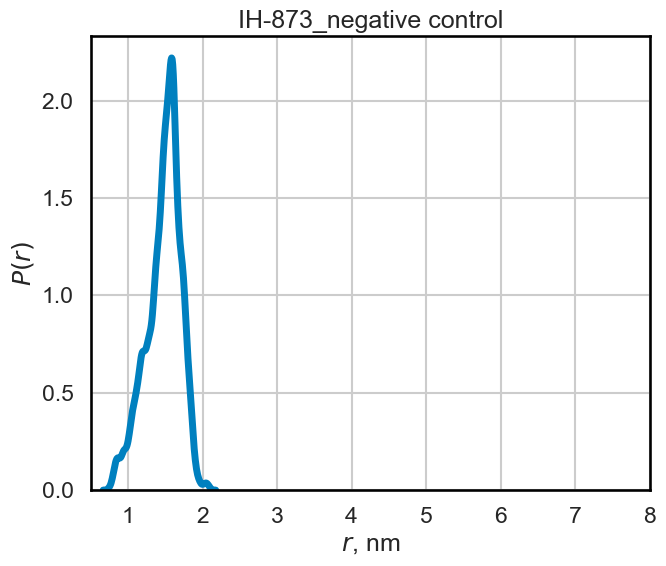

In [8]:

sns.kdeplot(data=coords, x="distance", color='#0080bf', common_norm=True, linewidth=5)

plt.xlabel('$r$, nm')
plt.ylabel('$P(r)$')

plt.xlim([0.5,8])
plt.title(title)

plt.gcf().set_size_inches(7, 6)

plt.savefig('kde.png', dpi=600)

plt.tight_layout()
plt.show()


Relative energy with time

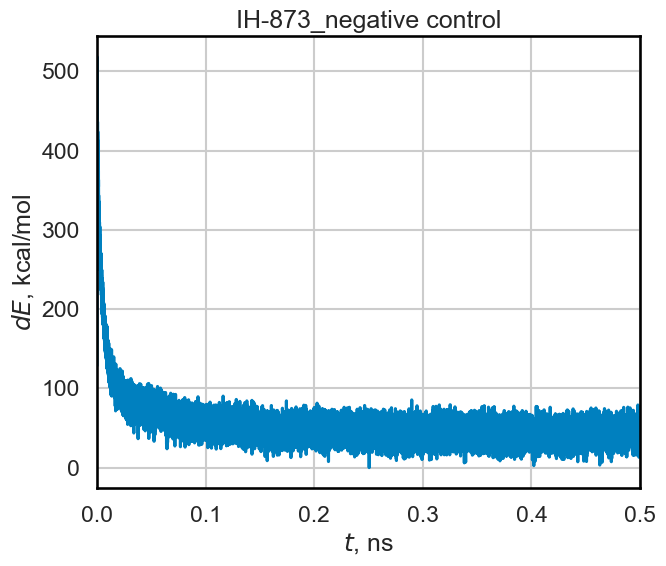

In [9]:
sns.lineplot(data=coords, x="time", y="rel_energy", color='#0080bf')

plt.xlim(0, total_time*1000)

ax = plt.gca()
ax.xaxis.set_major_formatter(fmt)
plt.title(title)
plt.xlabel('$t$, ns')
plt.ylabel('$dE$, kcal/mol')
plt.gcf().set_size_inches(7, 6)
plt.tight_layout()
plt.show()

First 5 ps to see how much should be removed.

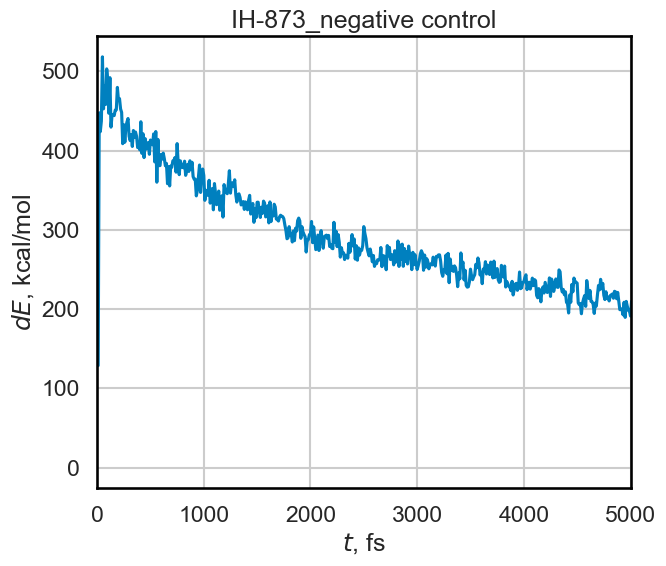

In [10]:
sns.lineplot(data=coords, x="time", y="rel_energy", color='#0080bf')

plt.xlim(0, 5000)


plt.title(title)
plt.xlabel('$t$, fs')
plt.ylabel('$dE$, kcal/mol')
plt.gcf().set_size_inches(7, 6)
plt.tight_layout()
plt.show()